In [2]:
library(NormqPCR)
library(pheatmap)
library(readxl)
library(plotrix)

Loading required package: RColorBrewer

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: ReadqPCR

Loading required package: qpcR

Loading required package: MASS

Loadi

In [3]:
library(EnhancedVolcano)
library('tidyr')

Loading required package: ggplot2

Loading required package: ggrepel


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack




In [4]:
######################################## 
### FUNCTION FOR RLE-PLOT AND RUV_total
########################################

RLEplot_mod <- function(data,pdata_group){
  
Color_Batches <- c('purple','orange','brown','blue','darkgreen','pink','gray','red','black','green','navy','Violet')
par(mar = c(6.5,6.5,2.3,0))
boxplot(data - rowMedians(data), main = '', xlab ='', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1,4.1),xlim=c(0,50),
        outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
        staplelwd = 0 , boxcol = Color_Batches[factor(pdata_group)],
        border = Color_Batches[factor(pdata_group)], col = 'gray87')
box(lwd = 7, bty = 'l')
title('RLE plot', line = -2, cex.main = 3.5)
Median_Nano <- apply(data - rowMedians(data), 2, median)
points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
axis(2, mgp = c(3.5, .9 ,0), lwd.ticks=6, las=1, cex.axis=3)
mtext('RLE', 2, line = 3.5, cex = 3.5)
abline(h = 0, col = 'black', lwd = 5, lty = 2)
par(lwd = 3)
axis.break(2, -4.2, style = 'zigzag', brw = .02)
x_labs <- levels(factor(colnames(data)))

text(x = seq_along(x_labs), y = -4.5, labels = x_labs, 
     srt = 90,    # rotate
     adj = 1,    # justify
     xpd = TRUE)    # plot in margin

legend(36, 4.1, legend = unique(factor(pdata_group)),
       col = unique(Color_Batches[factor(pdata_group)]),
       pch = 15, bty = 'n', cex = 1)
text(x = 40, y = 4.2 ,labels  = 'Run', cex = 1.5)

}

In [5]:
##### FUNCTION FOR RUVg  ### Bhattacharia et. al. 

RUV_total <- function(raw,pData,fData,k,hkgenes = NULL,exclude = NULL){
  
  library(RUVSeq)
  library(DESeq2)
  library(limma)
  library(matrixStats)
  
  if (!is.null(hkgenes)){
    
    fData(set)$CodeClass[rownames(set) %in% hkgenes] = 'Housekeeping'
    
  }
  
  
  fData = fData[rownames(raw),]
  int = intersect(rownames(raw),rownames(fData))
  fData = fData[int,]
  raw = raw[int,]
  
  set <- newSeqExpressionSet(as.matrix(round(raw)),
                             phenoData=pData,
                             featureData=fData)
  
  cIdx <- rownames(set)[fData(set)$`Class Name` == "Housekeeping"]
  cIdx = cIdx[!(cIdx %in% exclude)]
  x <- as.factor(pData$Group)
  set <- betweenLaneNormalization(set, which="upper")
  set <- RUVg(set, cIdx, k=k)
  dds <- DESeqDataSetFromMatrix(counts(set),colData=pData(set),design=~1)
  rowData(dds) <- fData
  dds <- estimateSizeFactors(dds)
  dds <- estimateDispersionsGeneEst(dds)
  cts <- counts(dds, normalized=TRUE)
  disp <- pmax((rowVars(cts) - rowMeans(cts)),0)/rowMeans(cts)^2
  mcols(dds)$dispGeneEst <- disp
  dds <- estimateDispersionsFit(dds, fitType="mean")
  vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
  mat <- assay(vsd)
  covars <- as.matrix(colData(dds)[,grep("W",colnames(colData(dds))),drop=FALSE])
#   mat_has_na = count(is.na(mat))
#   covar_has_na = count(is.na(covars))
#   if (mat_has_na > 0) {
#       print('mat has na values')
#   }
#   if (covar_has_na > 0) {
#       print('covar has na values')
#       print(covars)
#   }
  
  mat <- removeBatchEffect(mat, covariates=covars)
  assay(vsd) <- mat
  return(list(set = set,vsd = vsd))
  
}

In [6]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [7]:
RLEplot_mod <- function(data, pdata_group) {
  
  Color_Batches <- c('purple', 'orange', 'brown', 'blue', 'darkgreen', 'pink', 'gray', 'red', 'black', 'green', 'navy', 'Violet')
  
  par(mar = c(6.5, 6.5, 2.3, 2.3))  # Adjust the margin parameters
  par(plt = c(0.1, 0.9, 0.1, 0.9))  # Adjust the plot area parameters
  boxplot(data - rowMedians(data), main = '', xlab = '', ylab = '', xaxt = 'n', yaxt = 'n', ylim = c(-4.1, 4.1), xlim = c(0, 50),
          outline = FALSE, names = FALSE, frame = FALSE, whisklty = 3, whisklwd = 1.5, staplelty = 1, notch = TRUE, boxlwd = 2,
          staplelwd = 0, boxcol = Color_Batches[factor(pdata_group)],
          border = Color_Batches[factor(pdata_group)], col = 'gray87')
  box(lwd = 7, bty = 'l')
  title('RLE plot', line = -2, cex.main = 3.5)
  Median_Nano <- apply(data - rowMedians(data), 2, median)
  points(c(1:ncol(data)), Median_Nano, col = Color_Batches[factor(pdata_group)], pch = 19, cex = 1.2)
  axis(2, mgp = c(3.5, .9, 0), lwd.ticks = 6, las = 1, cex.axis = 3)
  mtext('RLE', 2, line = 3.5, cex = 3.5)
  abline(h = 0, col = 'black', lwd = 5, lty = 2)
  par(lwd = 3)
  axis.break(2, -4.2, style = 'zigzag', brw = .02)
  x_labs <- levels(factor(colnames(data)))
  text(x = seq_along(x_labs), y = -4.5, labels = x_labs,
       srt = 90,    # rotate
       adj = 1,    # justify
       xpd = TRUE)    # plot in margin
  
  legend(36, 4.1, legend = unique(factor(pdata_group)),
         col = unique(Color_Batches[factor(pdata_group)]),
         pch = 15, bty = 'n', cex = 1)
  text(x = 40, y = 4.2, labels = 'Run', cex = 1.5)
  
}

In [8]:
raw = read.csv('Data/raw_count_transponsed_raw.csv', row.names = 1, check.names = F )
norm_count = read.csv('Data/raw_count.csv', row.names = 1, check.names = F)
# sample annotations:
# annot = read.csv('Data/annot_3.csv', row.names = 1, check.names = F )
annot = read.csv('Data/annot_clinical.csv', row.names = 1, check.names = F )
# annot = read.csv('Data/annot_clinical_2.csv', row.names = 1, check.names = F )

# gene annotations:
gannot = read.csv('Data/gannot_raw.csv', row.names = 1, check.names = F )
old_gannot=read.csv('Data/gannot.csv', row.names = 1, check.names = F)
clin = read.csv('Data/annot.csv', row.names = 1, check.names = F )

In [9]:
raw_expression <- raw
dim(raw_expression)

[1] 784  48

In [11]:
fData=gannot
head(fData)

,Class Name,% Samples above Threshold,Immune Response Category,Accession,Common Name,Gene_Class
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
A2M,Endogenous,100,Chemokines,NM_000014.4,A2M,Immune Response
ABCB1,Endogenous,100,,NM_000927.3,ABCB1,Immune Response
ABCF1,Housekeeping,100,,NM_001090.2,ABCF1,HK
ABL1,Endogenous,100,"Cell Cycle, Regulation, Senescence",NM_005157.3,ABL,Immune Response
ADA,Endogenous,100,"B-Cell Functions, T-Cell Functions",NM_000022.2,ADA,Immune Response
ADORA2A,Endogenous,100,Cell Functions,NM_000675.3,ADORA2A,Immune Response - Checkpoint


In [12]:
fData$IsControl = fData$`Class Name`!='Endogenous'

In [38]:
l1 = row.names(fData[fData$`Class Name`=='Negative',])
l2 = row.names(fData[fData$`Class Name`=='Positive',])

In [40]:
exclude= c(l1, l2)
exclude
cIdx <- rownames(raw_expression)
cIdx = cIdx[!(cIdx %in% exclude)]

[1] "NEG_A" "NEG_B" "NEG_C" "NEG_D" "NEG_E" "NEG_F" "NEG_G" "NEG_H" "POS_A"
[10] "POS_B" "POS_C" "POS_D" "POS_E" "POS_F"

In [41]:
raw_expression_ex = raw_expression
raw_expression_ex = raw_expression[cIdx,]

In [42]:
pData <- annot[colnames(raw_expression),]
pData

,Conditions,Diagnosis,pid,Is_matched,Subject_ID,RECIST_response,TTP2n,group
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
20230616_210462891024_K1241-B_02.RCC,Soft Tissue Sarcoma,Baseline,K1241,True,TI0045,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1628-B_03.RCC,Soft Tissue Sarcoma,Baseline,K1628,True,TI0036,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K1865-B_04.RCC,Osteosarcoma,Baseline,K1865,False,TI0004,PD,PFS3.N,ADVANCED OSTEOSARCOMA
20230616_210462891024_K2032-B_05.RCC,Soft Tissue Sarcoma,Baseline,K2032,True,TI0047,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2068-B_06.RCC,Soft Tissue Sarcoma,Baseline,K2068,False,TI0035,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2323-B_07.RCC,Soft Tissue Sarcoma,Baseline,K2323,False,TI0033,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2360-B_08.RCC,Soft Tissue Sarcoma,Baseline,K2360,True,TI0030,SD,PFS3.Y,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2520-B_09.RCC,Soft Tissue Sarcoma,Baseline,K2520,False,TI0012,PD,PFS3.N,OTHER ADVANCED SARCOMAS
20230616_210462891024_K2669-B_10.RCC,Soft Tissue Sarcoma,Baseline,K2669,False,TI0059,SD,PFS3.Y,OTHER ADVANCED SARCOMAS


In [43]:
fData_ex = fData
fData_ex = fData[cIdx,]

In [44]:
k = 3  
vsd = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$vsd ## put exclude if there any hk associated with biology of interest 
set = RUV_total(raw_expression_ex,pData,
                fData_ex,k = k)$set # ,exclude = exc

converting counts to integer mode

converting counts to integer mode



In [45]:
normalizedcount <- set@assayData[["normalizedCounts"]]

In [46]:
col_data = pData(set)

In [47]:
count_data = counts(set)

In [64]:
# dds_w1_2 <- DESeqDataSetFromMatrix(countData = count_data,
#                               colData = col_data,
#                                    design= ~ W_1 +  RECIST_response ) #counts(set)[1:652,], ##use design with W_1 or W_2 based on k value
dds_w1_2 <- DESeqDataSetFromMatrix(countData = count_data,
                              colData = col_data,
                                   design= ~  RECIST_response ) #counts(set)[1:652,], ##use design with W_1 or W_2 based on k value
dds_w1_2 <- DESeq(dds_w1_2)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 66 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [70]:
keep <- rowSums(counts(dds_w1_2) >= 10) >= 3
dds_w1_2 <- dds_w1_2[keep,]

In [71]:
resultsNames(dds_w1_2)

[1] "Intercept"                "RECIST_response_SD_vs_PD"

In [72]:
res_valcanoplot2 <- results(dds_w1_2)

In [73]:
firstC <- 'SD'
SecondC <- 'PD'
contrast<- c("RECIST_response",firstC,SecondC)

In [74]:
res1_2 <- results(dds_w1_2, name="RECIST_response_SD_vs_PD")
res_deseq2_2 <- as.data.frame(results(dds_w1_2))
nam <- paste('up_in',firstC, sep = '_')
res_deseq2_2[, nam] <- as.logical(res_deseq2_2$log2FoldChange > 0)

res_deseq2_2$threshold <- as.logical(res_deseq2_2$padj < 0.05)  #Threshold defined earlier
row.names(res_deseq2_2)[which(res_deseq2_2$threshold)]

[1] "A2M"                       "AICDA"                    
  [3] "AMBP"                      "ARG1"                     
  [5] "ATF1"                      "ATG10"                    
  [7] "ATM"                       "BCL10"                    
  [9] "BID"                       "BIRC5"                    
 [11] "BLK"                       "BST2"                     
 [13] "C1QB"                      "C2"                       
 [15] "C6"                        "C8A"                      
 [17] "C9"                        "CAMP"                     
 [19] "CARD9"                     "CASP3"                    
 [21] "CCL1"                      "CCL15"                    
 [23] "CCL16"                     "CCL20"                    
 [25] "CCL22"                     "CCL24"                    
 [27] "CCL25"                     "CCL7"                     
 [29] "CCND3"                     "CCR1"                     
 [31] "CCR3"                      "CCR6"                     
 [33] "CCR9"                      "CD19"                     
 [35] "CD1A"                      "CD207"                    
 [37] "CD24"                      "CD36"                     
 [39] "CD4"                       "CD47"                     
 [41] "CD53"                      "CD58"                     
 [43] "CD63"                      "CD68"                     
 [45] "CD7"                       "CD74"                     
 [47] "CD79A"                     "CD79B"                    
 [49] "CD84"                      "CDH1"                     
 [51] "CDK1"                      "CEBPB"                    
 [53] "CFP"                       "CLEC6A"                   
 [55] "CMA1"                      "CMKLR1"                   
 [57] "COLEC12"                   "CR2"                      
 [59] "CRP"                       "CSF3"                     
 [61] "CTAG1B"                    "CTAGE1"                   
 [63] "CTCFL"                     "CTSG"                     
 [65] "CTSH"                      "CTSS"                     
 [67] "CXCL1"                     "CXCL2"                    
 [69] "CXCL6"                     "CXCR1"                    
 [71] "CXCR5"                     "CYBB"                     
 [73] "CYFIP2"                    "CYLD"                     
 [75] "DDX43"                     "DEFB1"                    
 [77] "DMBT1"                     "DUSP4"                    
 [79] "ELANE"                     "F2RL1"                    
 [81] "FAS"                       "FCER2"                    
 [83] "FEZ1"                      "FLT3"                     
 [85] "FOXP3"                     "FUT5"                     
 [87] "FUT7"                      "GAGE1"                    
 [89] "HAMP"                      "HAVCR2"                   
 [91] "HLA-DMA"                   "HLA-DPA1"                 
 [93] "HLA-DPB1"                  "HLA-DRA"                  
 [95] "HRAS"                      "ICOSLG"                   
 [97] "IFI27"                     "IFIH1"                    
 [99] "IFIT1"                     "IFITM1"                   
[101] "IFNA17"                    "IFNA2"                    
[103] "IFNA7"                     "IFNA8"                    
[105] "IFNB1"                     "IFNG"                     
[107] "IFNL1"                     "IFNL2"                    
[109] "IGLL1"                     "IL12A"                    
[111] "IL12B"                     "IL13"                     
[113] "IL13RA1"                   "IL17A"                    
[115] "IL17F"                     "IL18"                     
[117] "IL18RAP"                   "IL1RAPL2"                 
[119] "IL2"                       "IL21"                     
[121] "IL22"                      "IL22RA1"                  
[123] "IL22RA2"                   "IL23A"                    
[125] "IL23R"                     "IL25"                     
[127] "IL27"                      "IL3"                      
[129] "IL3RA"                     

In [75]:
norm_mean_w1_2 <- sapply( levels(dds_w1_2$RECIST_response), function(lvl) rowMeans( counts(dds_w1_2,normalized=TRUE)[,dds_w1_2$RECIST_response == lvl, drop=F] ) )
colnames(norm_mean_w1_2) <- paste('Rowmean_exp_',levels(dds_w1_2$RECIST_response),sep='')
res3_2 <- cbind(norm_mean_w1_2,res_deseq2_2)
top_de_genes_2 = na.omit(res3_2[res3_2$threshold==TRUE,])
top_de_genes_2   

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_SD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
A2M,6342.845705,2934.607578,4780.736563,-1.1119429,0.4142688,-2.684110,7.272319e-03,2.758466e-02,FALSE,TRUE
AICDA,9.545459,24.094082,16.213578,1.3440242,0.2737709,4.909302,9.140091e-07,7.037870e-05,TRUE,TRUE
AMBP,114.943541,433.238211,8.736687,0.8977697,0.2195055,4.089964,4.314406e-05,8.742350e-04,TRUE,TRUE
ARG1,27.484827,46.557015,9.030083,0.7860744,0.2511602,3.129773,1.749417e-03,9.904785e-03,TRUE,TRUE
ATF1,237.212651,169.678405,206.259455,-0.4737593,0.1728341,-2.741121,6.122999e-03,2.461588e-02,FALSE,TRUE
ATG10,95.337057,66.068042,81.922092,-0.5192292,0.1963198,-2.644813,8.173616e-03,2.952676e-02,FALSE,TRUE
ATM,12.675798,19.946368,16.008143,0.6173942,0.2181129,2.830617,4.645829e-03,2.022258e-02,TRUE,TRUE
BCL10,224.613330,168.606737,198.943642,-0.4157302,0.1509814,-2.753519,5.895832e-03,2.414782e-02,FALSE,TRUE
BID,12.039131,23.777246,17.419101,0.9813538,0.2043202,4.803020,1.562902e-06,9.257190e-05,TRUE,TRUE


In [54]:
colnames(top_de_genes_2)

[1] "Rowmean_exp_PD" "Rowmean_exp_SD" "baseMean"       "log2FoldChange"
 [5] "lfcSE"          "stat"           "pvalue"         "padj"          
 [9] "up_in_SD"       "threshold"

In [55]:
library(dplyr)

In [32]:
top_genes <- top_de_genes_2 %>%
  arrange(padj) %>%  # Arrange by ascending padj values
  top_n(35, wt = -padj)  # Select the top 35 genes based on padj values
top_genes

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_SD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
CXCL1,29.649725,259.70223,135.090459,3.1894673,0.4397902,7.252248,4.099105e-13,3.213699e-10,TRUE,TRUE
DUSP4,52.010415,343.38289,185.556132,2.6621869,0.3998973,6.657176,2.791381e-11,1.094221e-08,TRUE,TRUE
CXCL6,12.401719,50.53192,29.878062,2.0335687,0.3767077,5.398267,6.728773e-08,1.758453e-05,TRUE,TRUE
EIF2B4,352.473032,241.53131,301.624744,-0.5810827,0.1113977,-5.216290,1.825419e-07,3.279724e-05,FALSE,TRUE
NEG_B,10.352353,25.61528,17.347860,1.1995499,0.2310826,5.191001,2.091661e-07,3.279724e-05,TRUE,TRUE
XCR1,23.078644,45.21205,33.223122,0.8795725,0.1713571,5.132981,2.851893e-07,3.726473e-05,TRUE,TRUE
IL21,7.399186,16.96809,11.784933,1.1015925,0.2181194,5.050411,4.408607e-07,4.320435e-05,TRUE,TRUE
ISG15,813.544882,216.17910,539.752231,-1.9072555,0.3776128,-5.050824,4.399089e-07,4.320435e-05,FALSE,TRUE
CCL25,11.228422,26.53684,18.244779,1.1735203,0.2354345,4.984487,6.212641e-07,4.870710e-05,TRUE,TRUE


In [59]:
# Filter and select top 35 upregulated genes in 'SD' condition
top_upregulated_SD <- top_de_genes_2 %>%
  filter(up_in_SD == TRUE) %>%  # Filter for genes upregulated in 'SD'
  arrange(padj) %>%  # Arrange by ascending padj values
  slice_head(n = 25)  # Select the top 35 genes based on padj values

# Filter and select top 35 downregulated genes in 'SD' condition
top_downregulated_SD <- top_de_genes_2 %>%
  filter(up_in_SD == FALSE) %>%  # Filter for genes downregulated in 'SD'
  arrange(padj) %>%  # Arrange by ascending padj values
  slice_head(n = 25)  # Select the top 35 genes based on padj values
top_genes <- rbind(top_upregulated_SD, top_downregulated_SD)


In [60]:
top_genes

,Rowmean_exp_PD,Rowmean_exp_SD,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,up_in_SD,threshold
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
CXCL1,29.542193,263.66985,136.850704,3.2177775,0.4428199,7.266560,3.687579e-13,2.839436e-10,TRUE,TRUE
DUSP4,51.748470,346.99450,187.069567,2.6767779,0.4016139,6.665052,2.645710e-11,1.018598e-08,TRUE,TRUE
CXCL6,12.342079,51.27702,30.187262,2.0481547,0.3786281,5.409410,6.323284e-08,1.622976e-05,TRUE,TRUE
XCR1,22.967486,45.78854,33.427134,0.8979337,0.1739945,5.160702,2.460250e-07,3.970768e-05,TRUE,TRUE
IL21,7.360729,17.18609,11.864018,1.1194167,0.2202247,5.083066,3.713907e-07,4.766181e-05,TRUE,TRUE
CCL25,11.182101,26.85085,18.363613,1.1808279,0.2357234,5.009379,5.460596e-07,5.255824e-05,TRUE,TRUE
CTLA4,32.231651,116.52207,70.864758,2.0174549,0.4066389,4.961294,7.002519e-07,5.332801e-05,TRUE,TRUE
IL4,9.764453,23.78603,16.191010,1.2062932,0.2460391,4.902852,9.445529e-07,6.060881e-05,TRUE,TRUE
CCR3,5.985779,14.35539,9.821852,1.3298877,0.2803766,4.743220,2.103481e-06,1.079787e-04,TRUE,TRUE


Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


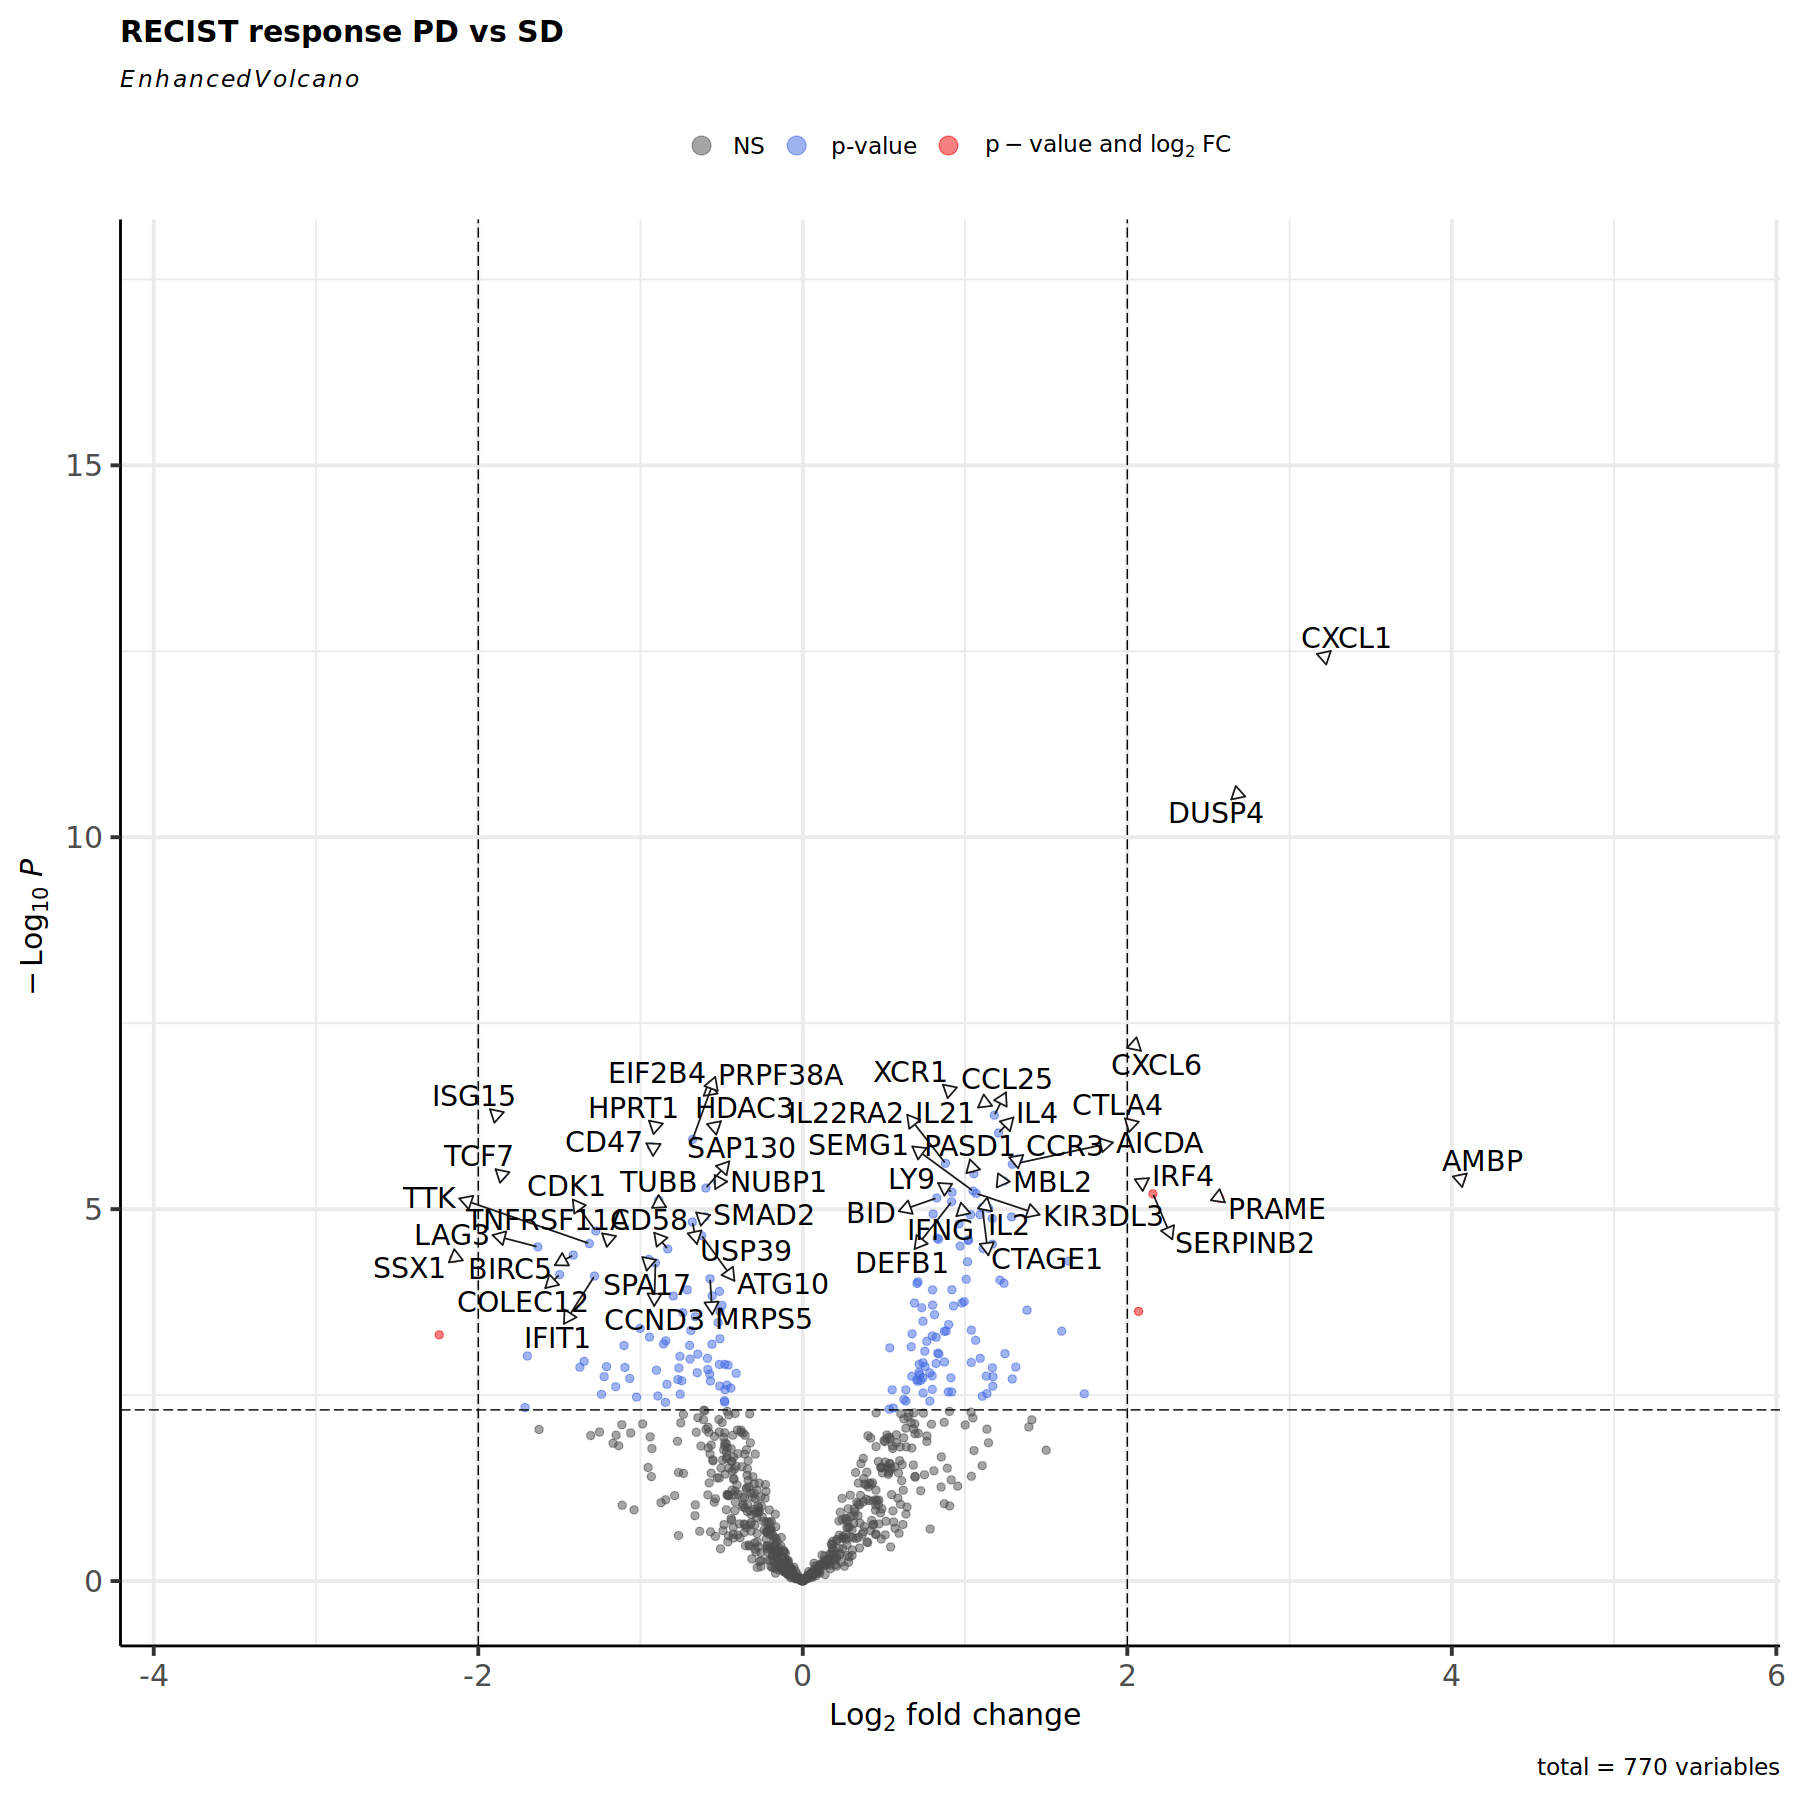

In [63]:
options(repr.plot.width=15, repr.plot.height=15)
EnhancedVolcano(res_valcanoplot2,
                lab = rownames(res_valcanoplot2),
                selectLab = row.names(top_genes),
                x = 'log2FoldChange',
                y = 'pvalue',
                title = 'RECIST response PD vs SD', drawConnectors = TRUE, max.overlaps = 35,
                pCutoff = 0.005,
                FCcutoff = 2.0,
                pointSize = 2.0,
                labSize = 6.0)

In [1]:
PD vs SD in the baseline


SyntaxError: invalid syntax (1469817397.py, line 1)

In [2]:
PD vs SD in the treatment

SyntaxError: invalid syntax (286713432.py, line 1)

In [3]:
plot the IL23 in baseline, 

SyntaxError: invalid syntax (2049151943.py, line 1)